In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utils import *
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
import numpy as np
import pickle
import os

from experiment import unpack_and_dequantize

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
# define results directories
cpt_dir = "../cpt/"
nocpt_dir = "../nocpt/"

# Heatmap for Dominant Amplitudes

### CPT

In [42]:
directory = "cpt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["lambduh"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

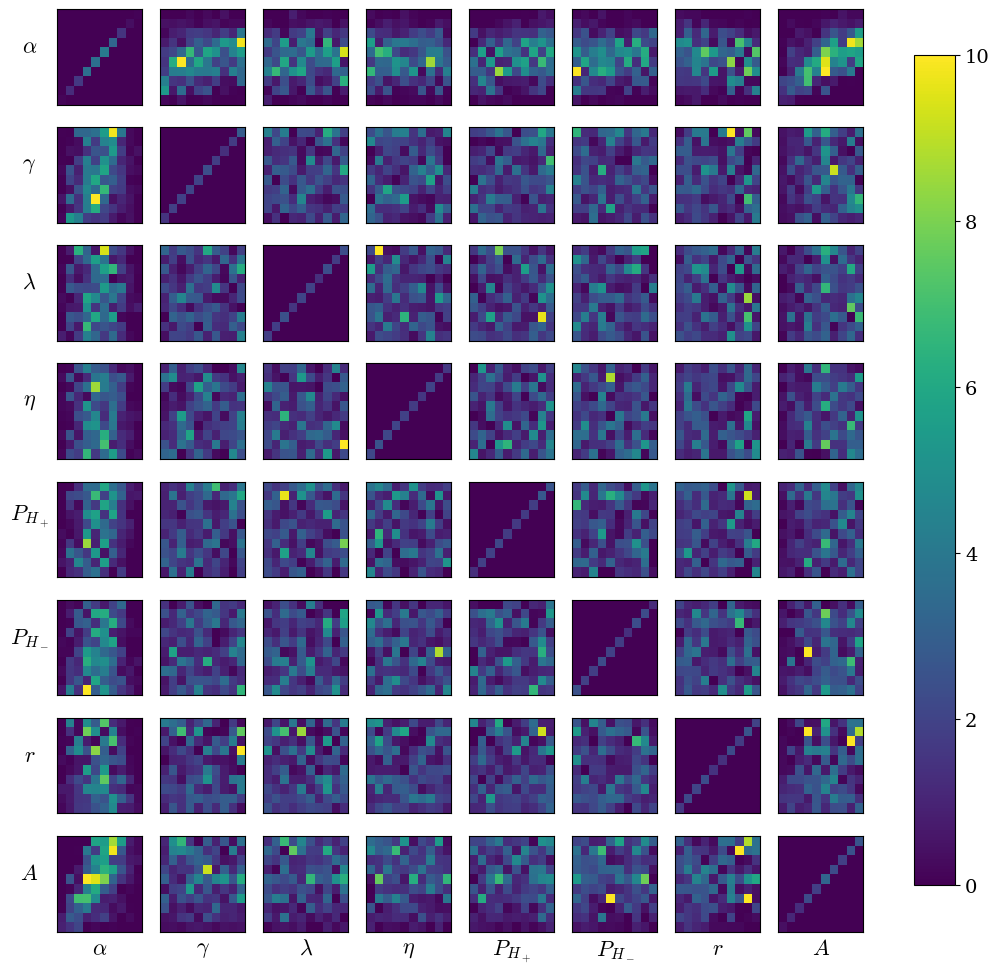

In [46]:
param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$r$", r"$A$"]
bounds = [[0.05,0.95], [0.5,0.8], [1.5,3], [0.65, 0.95], [0.05,0.95], [0.05,0.95], [1,5], [0.05,0.95]]
freq_lists = [d[-1] for d in data]

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=10)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### NO CPT

In [48]:
directory = "nocpt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

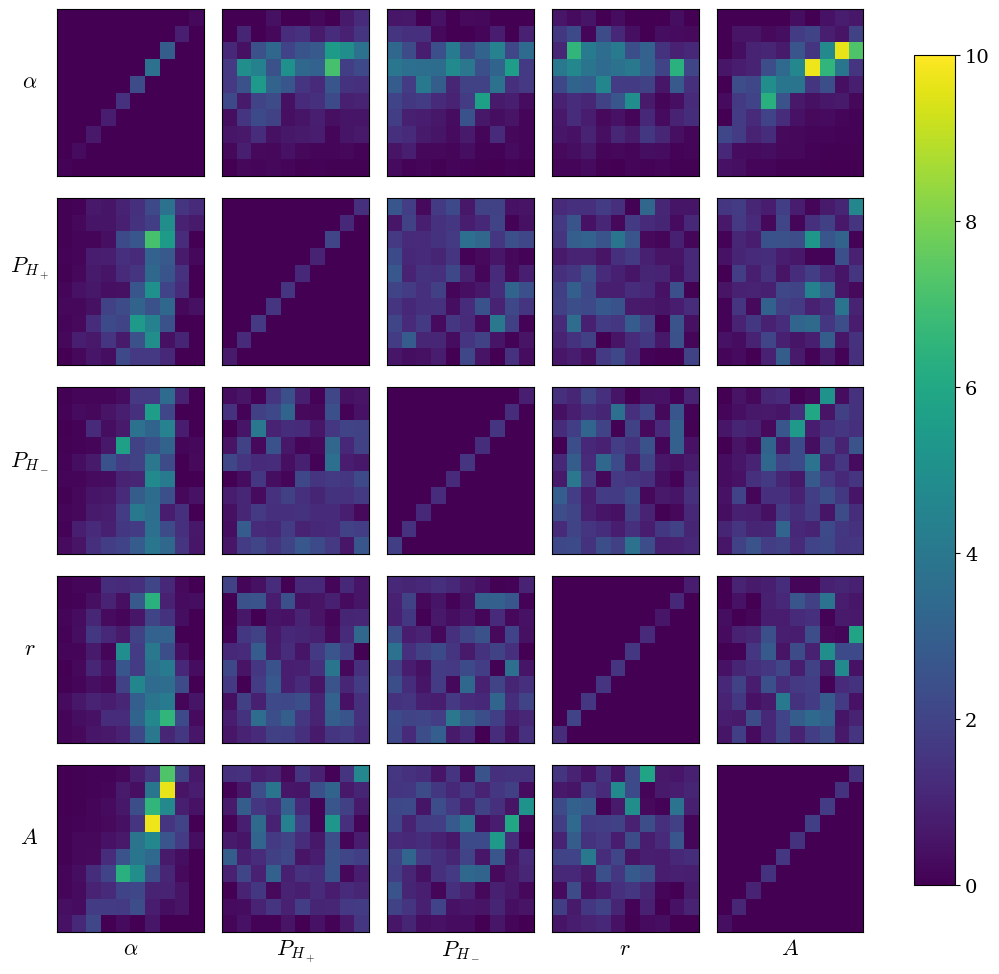

In [51]:
fig, axs = plt.subplots(5, 5, figsize=(11,10))


freq_lists = [d[-1] for d in data]
param_names = [r"$\alpha$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$r$", r"$A$"]
bounds = [[0.05,0.95], [0.05,0.95], [0.05,0.95], [1,5], [0.05,0.95]]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=10)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Amplitudes

2518.5869140625
2.0000004213905584 55.423200919792
3120.0693359375
2.000000753832292 49.408164255210195


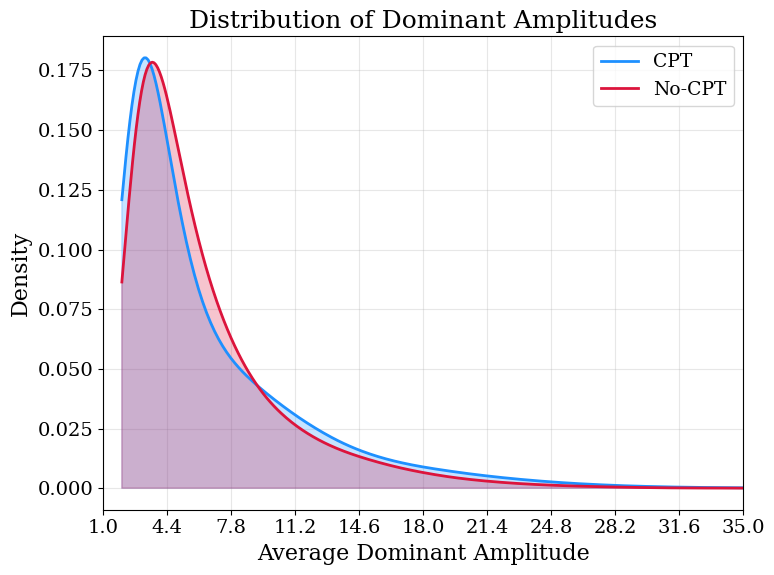

In [81]:
labels = ["CPT", "No-CPT"]
colors = ["dodgerblue", "crimson"]

for i, model in enumerate(["../cpt", "../nocpt"]):
    with open(model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)

    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]
    sims = sims[sims>=2.0]
    print(len(sims)/1024)
    print(sims.min(), sims.max())

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.2)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 500)
    y_vals = kde(x_vals)

    # normalize so area = 1 (proportion density)
    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)

plt.xlabel("Average Dominant Amplitude")
plt.ylabel("Density")
plt.title(f"Distribution of Dominant Amplitudes")
plt.legend()
plt.xlim(1,35)
plt.xticks(np.linspace(1, 35, 11))
plt.grid()
plt.tight_layout()
plt.show()

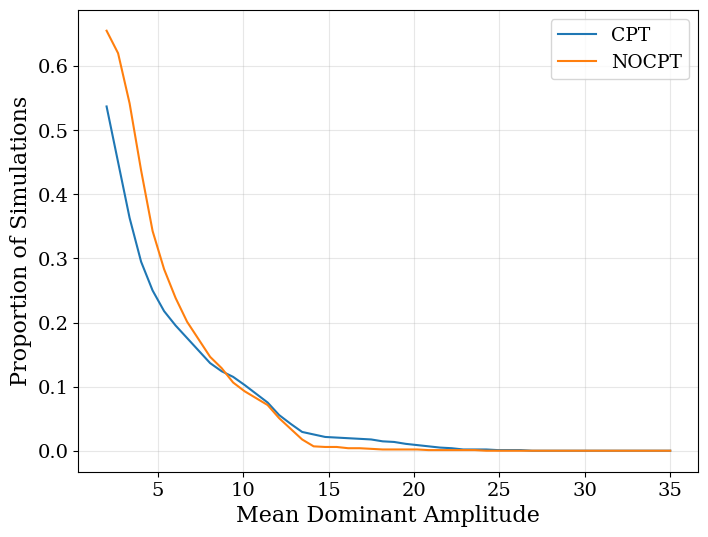

In [82]:
cutoffs = np.linspace(2, 35, 50)
for model in ["cpt", "nocpt"]:
    with open("../"+model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)
    count = []
    for mean_dominant_amplitude in cutoffs:
        sims = [x for x in amplitudes if np.mean(x["amplitudes"]) > mean_dominant_amplitude]
        count.append(len(sims)/1024)
    plt.plot(cutoffs, count, label=model.upper())

plt.legend()
plt.grid()
plt.xlabel("Mean Dominant Amplitude")
plt.ylabel("Proportion of Simulations")
plt.show()

# Heatmaps for Dominant Frequencies

### CPT

In [ ]:
directory = "cpt"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

0it [00:00, ?it/s]

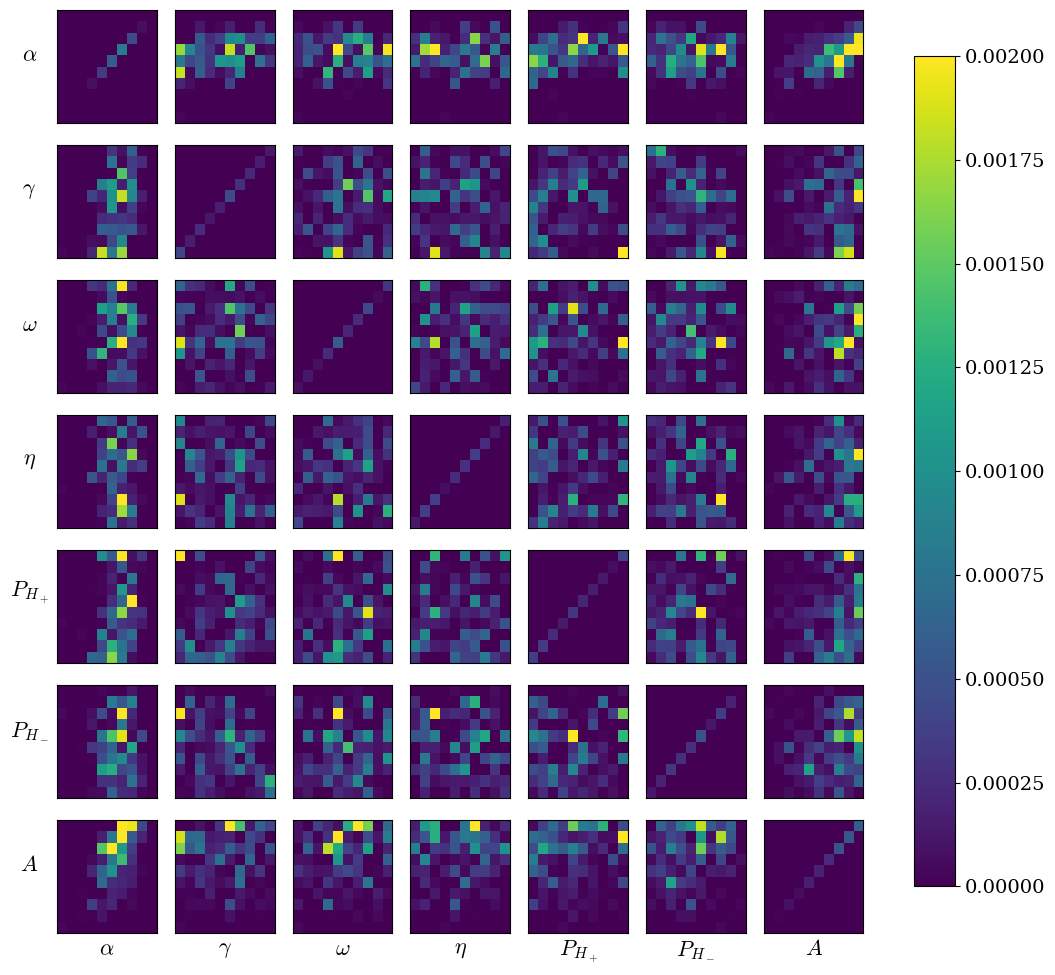

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    freq_lists_min_agents = [freq_lists[k] for k in idxs]
                    if freq_lists_min_agents:
                        combined_freqs = np.concatenate(freq_lists_min_agents) 
                        combined_freqs[np.isnan(combined_freqs)] = 0
                        heatmap[a, b] = combined_freqs.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=0.002)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### NO CPT

In [ ]:
directory = "nocpt"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

0it [00:00, ?it/s]

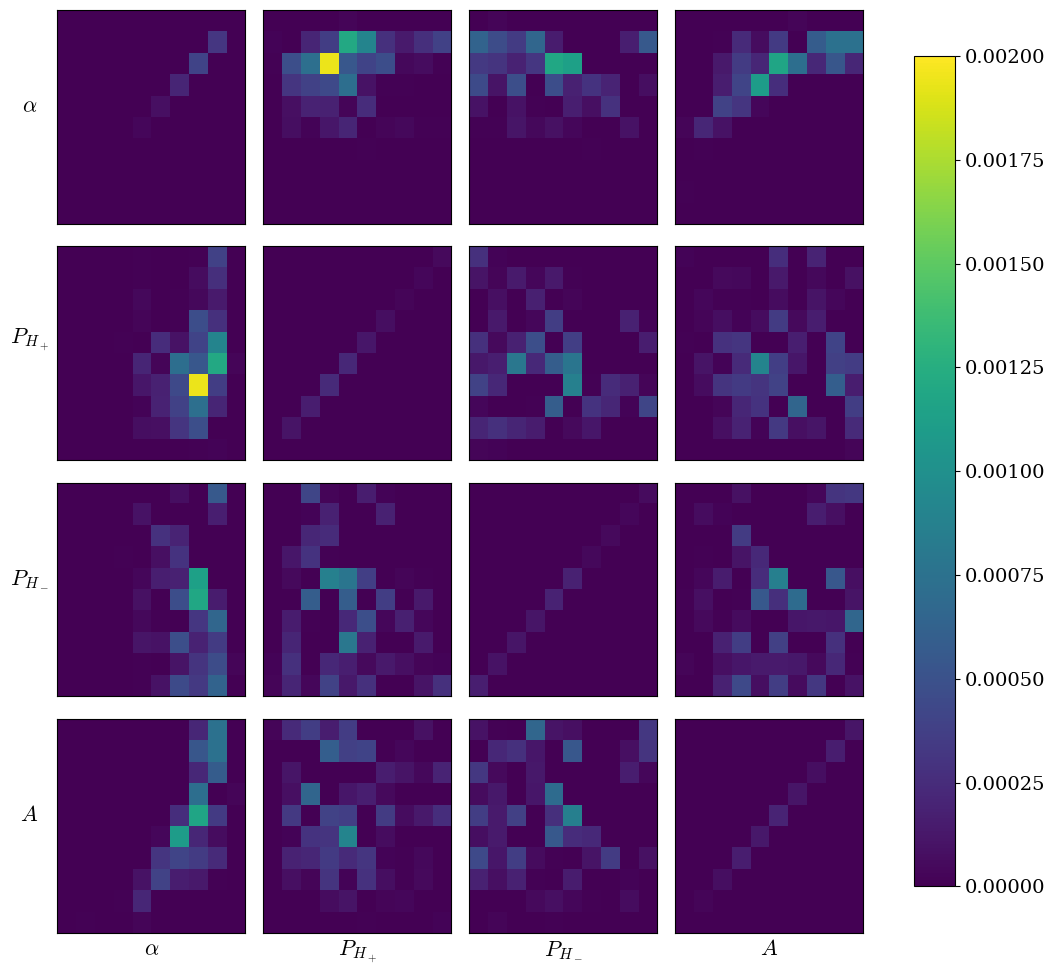

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    freq_lists_min_agents = [freq_lists[k] for k in idxs]
                    if freq_lists_min_agents:
                        combined_freqs = np.concatenate(freq_lists_min_agents) 
                        combined_freqs[np.isnan(combined_freqs)] = 0
                        heatmap[a, b] = combined_freqs.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=0.002)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# Heatmaps for Oscillation Location

### CPT

In [ ]:
directory = "cpt"
cutoff = 1000

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

oscillating_bool = [int(len(np.where(~np.isnan(s))[0]) >= cutoff) for s in freqs]

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], oscillating_bool[idx]))
    data.append(elem)

0it [00:00, ?it/s]

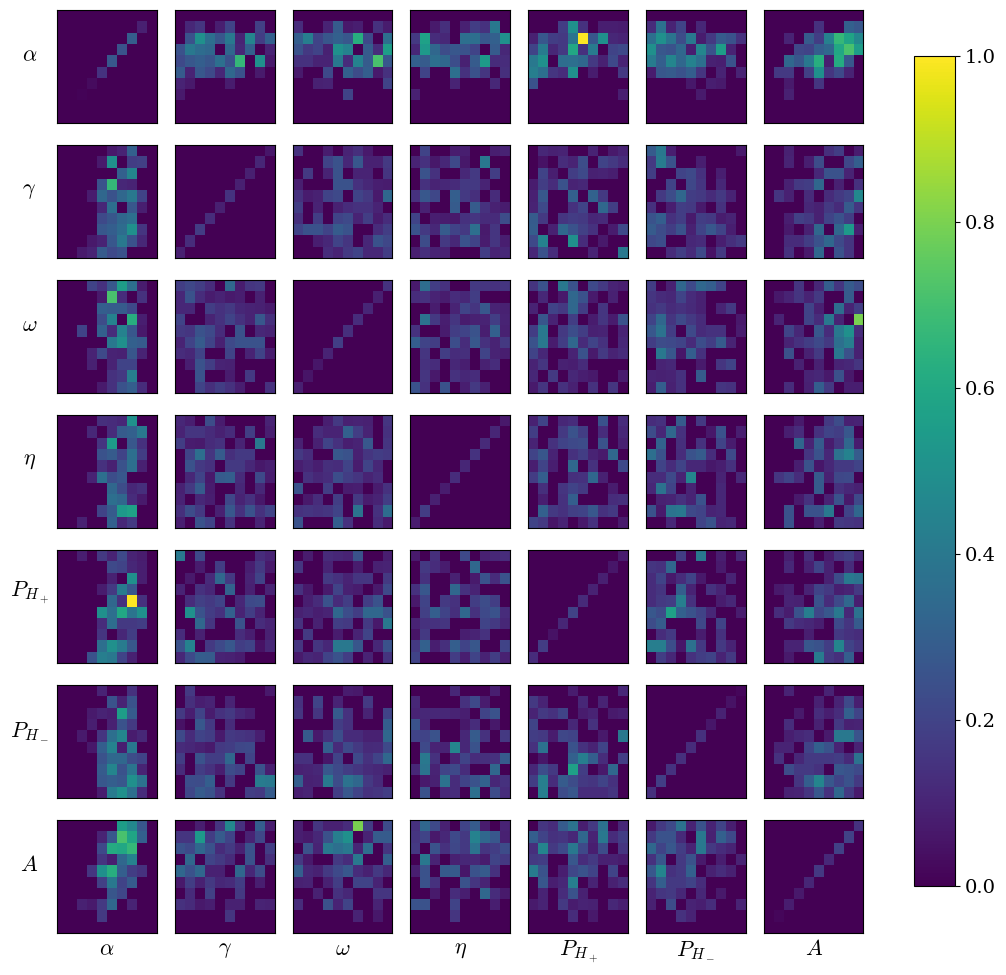

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = np.array([d[-1] for d in data])

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(freq_lists[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### NO CPT

In [ ]:
directory = "nocpt"
cutoff = 1000

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

oscillating_bool = [int(len(np.where(~np.isnan(s))[0]) >= cutoff) for s in freqs]

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], oscillating_bool[idx]))
    data.append(elem)

0it [00:00, ?it/s]

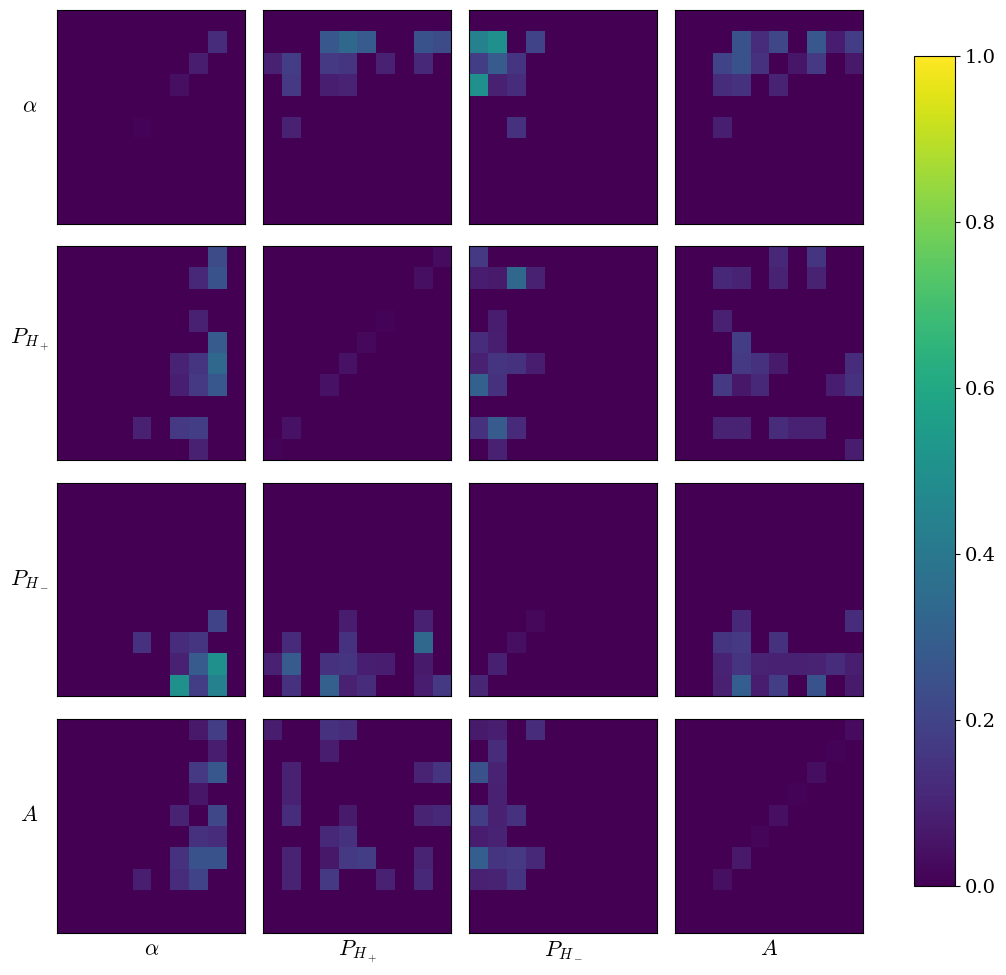

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
freq_lists = np.array([d[-1] for d in data])

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(freq_lists[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Freqs

0.0005 0.043000000000000003
0.0005 0.046


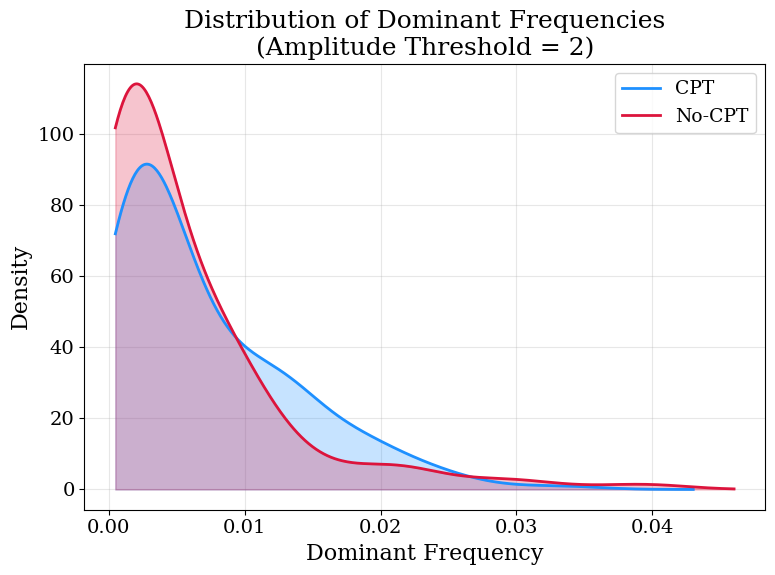

In [66]:
labels = ["CPT", "No-CPT"]
colors = ["dodgerblue", "crimson"]

threshold = 2

for i, directory in enumerate(["../cpt", "../nocpt"]):
    with open(directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        data = pickle.load(f)

    sims = [s["frequencies"] for s in data if np.mean(s["amplitudes"]) >= threshold]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]
    print(sims.min(), sims.max())

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.4)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 500)
    y_vals = kde(x_vals)

    # normalize so area = 1 (proportion density)
    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)

plt.xlabel("Dominant Frequency")
plt.ylabel("Density")
plt.title(f"Distribution of Dominant Frequencies\n(Amplitude Threshold = 2)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Radar Plots for Param Values

In [23]:
colors = ["dodgerblue", "crimson"]
directory = "cpt"

with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

sims = [int(np.mean(f["amplitudes"]) > 10) for f in freqs]

data = []
for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if f_name.endswith('.pickle'):
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            P = pickle.load(f)["params"]
        elem = ((P["alpha"], P["gamma"], P["lambduh"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], sims[idx]))
        data.append(elem)

  0%|          | 0/1024 [00:00<?, ?it/s]

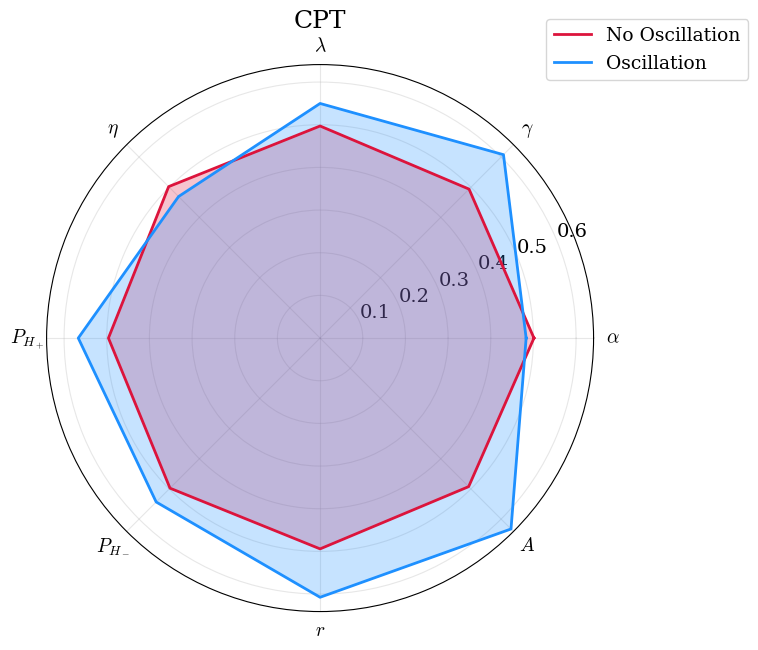

In [26]:
colors = ['dodgerblue', 'crimson']
data_array = np.array(data)

# Separate the data into two groups based on the simulation outcome
group_0 = data_array[data_array[:, -1] == 0][:, :-1]
group_1 = data_array[data_array[:, -1] == 1][:, :-1]

# Calculate the average parameter values for each group
avg_group_0 = np.mean(group_0, axis=0)
avg_group_1 = np.mean(group_1, axis=0)

# Calculate min and max for each parameter across the entire dataset
min_vals = np.min(data_array[:, :-1], axis=0)
max_vals = np.max(data_array[:, :-1], axis=0)

# Apply min-max normalization to the average values
normalized_avg_group_0 = (avg_group_0 - min_vals) / (max_vals - min_vals)
normalized_avg_group_1 = (avg_group_1 - min_vals) / (max_vals - min_vals)

num_vars = 8

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The radar plot needs to be a closed shape, so we repeat the first value at the end
normalized_avg_group_0 = np.concatenate((normalized_avg_group_0, [normalized_avg_group_0[0]]))
normalized_avg_group_1 = np.concatenate((normalized_avg_group_1, [normalized_avg_group_1[0]]))
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plotting the data for sims[idx] == 0
ax.plot(angles, normalized_avg_group_0, color=colors[1], linewidth=2, linestyle='solid', label='No Oscillation')
ax.fill(angles, normalized_avg_group_0, color=colors[1], alpha=0.25)

# Plotting the data for sims[idx] == 1
ax.plot(angles, normalized_avg_group_1, color=colors[0], linewidth=2, linestyle='solid', label='Oscillation')
ax.fill(angles, normalized_avg_group_1, color=colors[0], alpha=0.25)

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels([r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$\eta$", r"$P_{H_+}$", r"$P_{H_-}$", r"$r$", r"$A$"])

# Add a title and legend
plt.title("CPT")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
cutoff = 1000
colors = ["dodgerblue", "crimson"]
directory = "nocpt"

with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

sims = [int(np.mean(f["amplitudes"]) > 10) for f in freqs]

data = []
for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if f_name.endswith('.pickle'): # Ensure we only read the sim files
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            P = pickle.load(f)["params"]
        elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["rate"], P["w_delta_scale"], sims[idx]))
        data.append(elem)

  0%|          | 0/1024 [00:00<?, ?it/s]

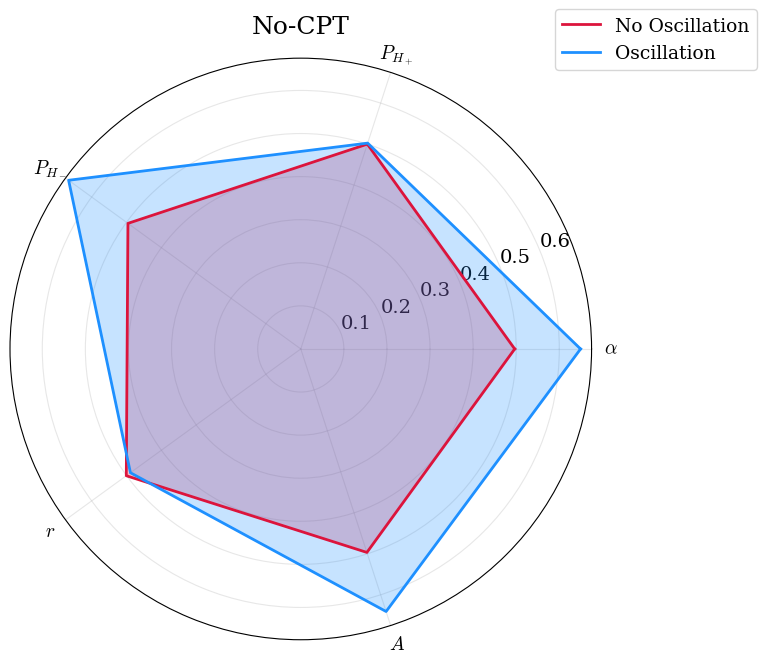

In [29]:
colors = ['dodgerblue', 'crimson']
data_array = np.array(data)

# Separate the data into two groups based on the simulation outcome
group_0 = data_array[data_array[:, -1] == 0][:, :-1]
group_1 = data_array[data_array[:, -1] == 1][:, :-1]

# Calculate the average parameter values for each group
avg_group_0 = np.mean(group_0, axis=0)
avg_group_1 = np.mean(group_1, axis=0)

# Calculate min and max for each parameter across the entire dataset
min_vals = np.min(data_array[:, :-1], axis=0)
max_vals = np.max(data_array[:, :-1], axis=0)

# Apply min-max normalization to the average values
normalized_avg_group_0 = (avg_group_0 - min_vals) / (max_vals - min_vals)
normalized_avg_group_1 = (avg_group_1 - min_vals) / (max_vals - min_vals)

num_vars = 5

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The radar plot needs to be a closed shape, so we repeat the first value at the end
normalized_avg_group_0 = np.concatenate((normalized_avg_group_0, [normalized_avg_group_0[0]]))
normalized_avg_group_1 = np.concatenate((normalized_avg_group_1, [normalized_avg_group_1[0]]))
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plotting the data for sims[idx] == 0
ax.plot(angles, normalized_avg_group_0, color=colors[1], linewidth=2, linestyle='solid', label='No Oscillation')
ax.fill(angles, normalized_avg_group_0, color=colors[1], alpha=0.25)

# Plotting the data for sims[idx] == 1
ax.plot(angles, normalized_avg_group_1, color=colors[0], linewidth=2, linestyle='solid', label='Oscillation')
ax.fill(angles, normalized_avg_group_1, color=colors[0], alpha=0.25)

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels([r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$r$", r"$A$"])

# Add a title and legend
plt.title("No-CPT")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.tight_layout()
plt.show()

# Large Mean Amplitude Simulations

  0%|          | 0/1024 [00:00<?, ?it/s]

{'N': 200, 'alpha': np.float64(0.5615340979984665), 'gamma': np.float64(0.7515995549721578), 'lambduh': np.float64(2.7014790889642466), 'eta': np.float64(0.6842343982252869), 'P_H_increase': np.float64(0.7313243006421629), 'P_H_decrease': np.float64(0.062141449610653716), 'rate': np.float64(4.808722044359312), 'w_delta_scale': np.float64(0.7780103624112138), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'health_shock_size': 0.9}


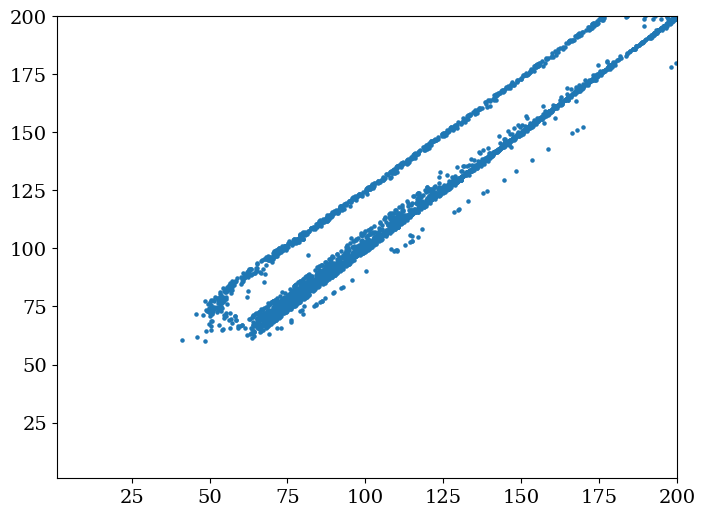

In [83]:
colors = ["dodgerblue", "crimson"]
directory = "cpt"

with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)
sims = [int(np.mean(f["amplitudes"]) > 26) for f in freqs]

data = []
for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if sims[idx]:
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            res = pickle.load(f)
        print(res["params"])
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        plt.scatter(w,h,s=5)
        plt.xlim(1,200)
        plt.ylim(1,200)
        plt.show()